In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

## read the train data and test data

In [19]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M')
dev = pd.read_csv('test.csv', index_col='date',date_parser=dateparse)
dev.head()

C:\Users\wu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


""
date
2018-01-01 02:00:00
2018-01-01 05:00:00
2018-01-01 07:00:00
2018-01-01 08:00:00
2018-01-01 10:00:00


In [20]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M')
data = pd.read_csv('train.csv', index_col='date',date_parser=dateparse)
data.head()

C:\Users\wu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,speed
date,
2017-01-01 00:00:00,43.002930
2017-01-01 01:00:00,46.118696
2017-01-01 02:00:00,44.294158
2017-01-01 03:00:00,41.067468
2017-01-01 04:00:00,46.448653


## Split the training set and the validation set

In [21]:
test = data[data.index>="2018-12-01"]
train = data[data.index<"2018-12-01"]

## Extract data features

In [22]:
def create_features(df, label=None):
    df['date'] = df.index # index: DatetimeIndex
    df['hour'] = df['date'].dt.hour # dt: DatetimeProperties, hour: Series
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear

    X = df[['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year', 'day_of_month', 'week_of_year']]
    if label:
        y = df[label]
        return X, y
    return X

# 训练集
X_train, y_train = create_features(train, label='speed')
# 测试集
X_test, y_test = create_features(test, label='speed')

X_all,y_all = create_features(data,label='speed')

X_dev = create_features(dev)

C:\Users\wu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\wu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\wu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

## the best results （xgboost）

In [35]:
reg = xgb.XGBRegressor(n_estimators=300, min_child_weight=2, max_depth=24,reg_alpha=9)
reg.fit(X_all, y_all)
mean_squared_error(y_true=y_test,
                   y_pred=reg.predict(X_test))

1.9665829022328272

In [24]:
y_pred = reg.predict(X_dev)
dataframe = pd.DataFrame({'id':range(len(y_pred)),'speed':y_pred})
dataframe.to_csv("answer.csv",index=False,sep=',')

## the best results （xgboost+lightgbm）

In [15]:
import lightgbm as lgb
params = {}

dtrain = lgb.Dataset(X_all, y_all)
bst = lgb.train(params,train_set=dtrain)

9.616798934857744

In [16]:
reg = xgb.XGBRegressor(n_estimators=250)
reg.fit(X_all, y_all)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=250, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [17]:
y_pred = reg.predict(X_dev)
y_pred2 = bst.predict(X_dev)
dataframe = pd.DataFrame({'id':range(len(y_pred)),'speed':y_pred*0.8+y_pred2*0.2})
dataframe.to_csv("answer.csv",index=False,sep=',')

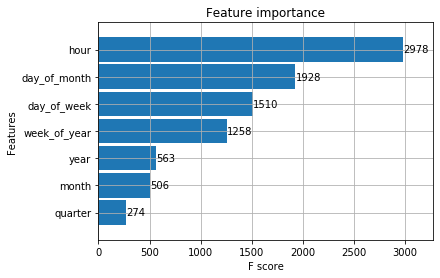

In [98]:
from xgboost import plot_importance
_ = plot_importance(reg, height=0.9)

## use gridsearch to find the best parameters

In [ ]:
cv_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]}
other_params = {'learning_rate': 0.1, 'n_estimators': 600, 'max_depth': 8, 'min_child_weight': 4, 'seed': 0,\
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 2, 'reg_lambda': 3}
# 模型
reg = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=reg, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
# 训练
optimized_GBM.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],verbose=False)
optimized_GBM.best_params_

## linear regression (not so good)

In [14]:
from sklearn.linear_model import Lasso
alpha_ridge = [1e-5, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]


coeffs = {}

for alpha in alpha_ridge:

    r = Lasso(alpha=alpha, normalize=True, max_iter=1000000)

    r = r.fit(X_train, y_train)


grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), scoring='neg_mean_squared_error',

                           param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Lasso(alpha=20, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 1, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Text(0, 0.5, 'rmse')

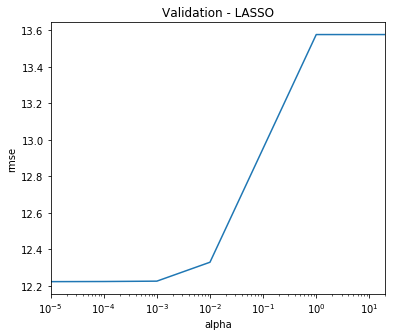

In [15]:
alpha = alpha_ridge

rmse = list(np.sqrt(-grid_search.cv_results_['mean_test_score']))


plt.figure(figsize=(6,5))

lasso_cv = pd.Series(rmse, index = alpha)

lasso_cv.plot(title = "Validation - LASSO", logx=True)

plt.xlabel("alpha")

plt.ylabel("rmse")

In [ ]:
lasso = Lasso(alpha=.00001, normalize=True, max_iter=1e6)

lasso = lasso.fit(X_train, y_train)
mean_squared_error(y_true=y_test,
                   y_pred=lasso.predict(X_test))

In [ ]:
import statsmodels.api as sm


# fit & predict
holt_winter = sm.tsa.ExponentialSmoothing(np.array(train['speed']),
                                          seasonal_periods=24*365,
                                          seasonal='add').fit()
y_hat_holt_winter = holt_winter.forecast(len(np.array(test['speed'])))

In [ ]:
mean_squared_error(y_true=y_test,
                   y_pred=holt_winter.forecast(len(np.array(test['speed']))))

## prophet(not so good)

In [ ]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [73]:
from fbprophet import Prophet
model = Prophet()
model.fit(pd.concat([X_all,y_all],axis=1).reset_index() \
              .rename(columns={'date':'ds',
                               'speed':'y'}))
test = model.predict(df=X_test.reset_index() \
                                   .rename(columns={'date':'ds'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [74]:
mean_squared_error(y_true=y_test,
                   y_pred=test['yhat'])

54.911057639036144

In [75]:
ans = model.predict(df=X_dev.reset_index() \
                                   .rename(columns={'date':'ds'}))

## visualization

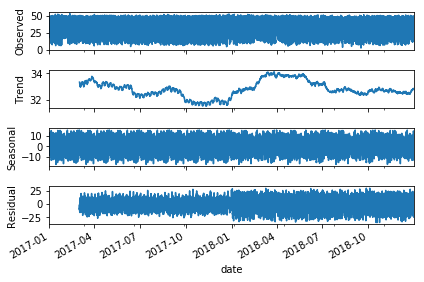

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, freq=1440, two_sided=False)
decomposition.plot()
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.show()

In [65]:
train = trend[:len(trend)-len(test)]
#arima的训练参数order =（p,d,q），具体意义查看官方文档，调参过程略。
self.trend_model = ARIMA(ts, order).fit(disp=-1, method='css')

NameError: name 'ARIMA' is not defined

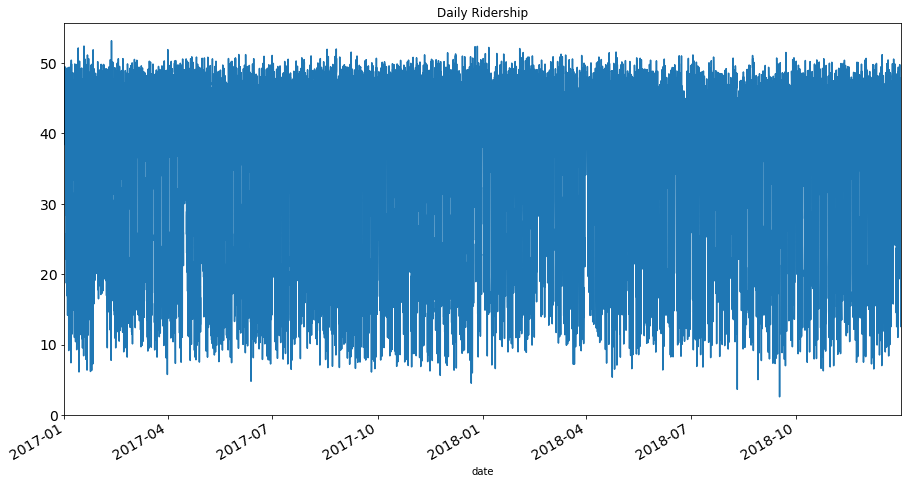

In [21]:
ts.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

In [22]:
test = pd.read_csv("test.csv")

In [46]:
test_x['x'] = []
for i in test['date']:
    test_x.append(i)

TypeError: list indices must be integers or slices, not str

In [45]:
y_hat_avg = test_x.copy()
y_hat_avg['moving_avg_forecast'] = ts.rolling(60).mean().iloc[-1]

TypeError: list indices must be integers or slices, not str

In [44]:
perdict

34.74695085616635

In [30]:
ts['2017-01-01 00:00:00':'2017-01-01 09:00:00']

date
2017-01-01 00:00:00    43.002930
2017-01-01 01:00:00    46.118696
2017-01-01 02:00:00    44.294158
2017-01-01 03:00:00    41.067468
2017-01-01 04:00:00    46.448653
2017-01-01 05:00:00    46.797766
2017-01-01 06:00:00    44.404925
2017-01-01 07:00:00    45.255897
2017-01-01 08:00:00    45.680859
2017-01-01 09:00:00    48.435676
Name: speed, dtype: float64

In [33]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [47]:
import matplotlib.pyplot as plt

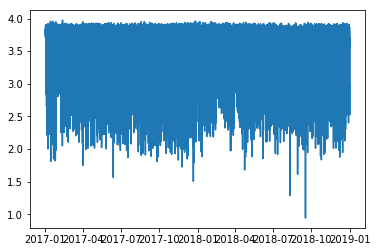

In [42]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [49]:
data.head()

,id,speed
date,,
2017-01-01 00:00:00,0,43.002930
2017-01-01 01:00:00,1,46.118696
2017-01-01 02:00:00,2,44.294158
2017-01-01 03:00:00,3,41.067468
2017-01-01 04:00:00,4,46.448653


In [70]:
data = data["speed"]

In [52]:
data.dropna().describe()

count    14006.000000
mean        32.779118
std         13.573813
min          2.573417
25%         19.301089
50%         36.580595
75%         45.877665
max         53.161286
Name: speed, dtype: float64

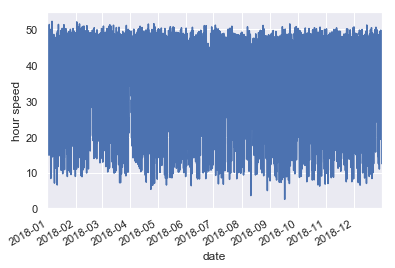

In [68]:
data.plot()
plt.ylabel('hour speed');

In [63]:
data = data['2018-01-01 00:00:00':'2018-12-31 20:00:00']

In [64]:
data.describe()

count    5256.000000
mean       33.043593
std        13.423436
min         2.573417
25%        19.890078
50%        36.910659
75%        45.871285
max        52.207573
Name: speed, dtype: float64

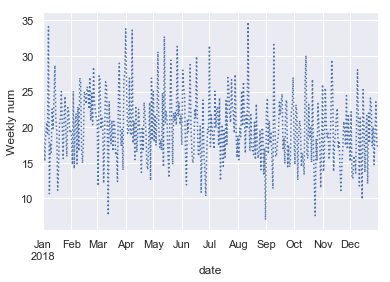

In [67]:
weekly = data.resample('D').sum()/24
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly num');

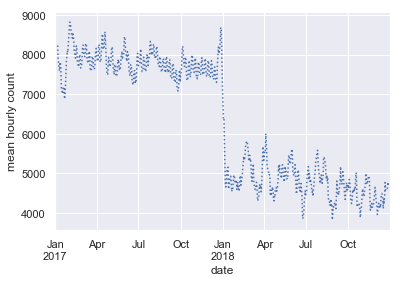

In [62]:
daily = data.resample('D').sum()
daily.rolling(10, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('mean hourly count');

In [57]:
weekly.head()

date
2017-01-01    1070.552523
2017-01-02     852.057708
2017-01-03     797.066855
2017-01-04     783.329974
2017-01-05     769.861439
Freq: D, Name: speed, dtype: float64

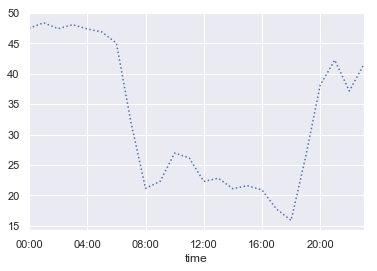

In [71]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']);

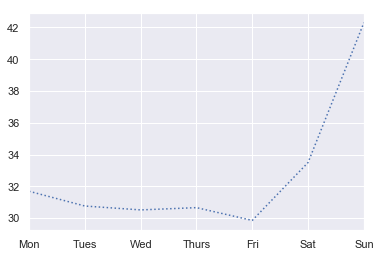

In [72]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-']);

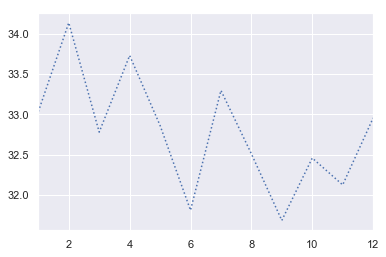

In [78]:
by_month = data.groupby(data.index.month).mean()
by_month.index = [1,2,3,4,5,6,7,8,9,10,11,12]
by_month.plot(style=[':', '--', '-']);

In [79]:
by_month

1     33.033615
2     34.134463
3     32.779616
4     33.728526
5     32.862373
6     31.811664
7     33.295946
8     32.511020
9     31.685903
10    32.458602
11    32.125893
12    32.954547
Name: speed, dtype: float64

In [74]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

C:\Users\wu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\wu\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


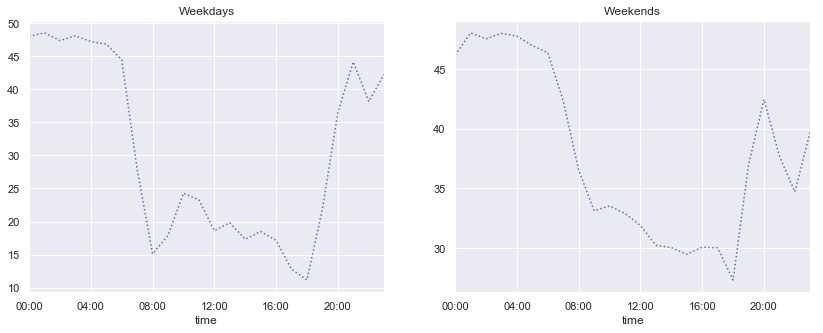

In [75]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.ix['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.ix['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

In [81]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M')
test = pd.read_csv('test.csv', index_col='date',date_parser=dateparse)
test.head()

,id
date,
2018-01-01 02:00:00,0
2018-01-01 05:00:00,1
2018-01-01 07:00:00,2
2018-01-01 08:00:00,3
2018-01-01 10:00:00,4


In [93]:
test = test['id']

In [94]:
trya = by_time.ix['Weekday']

C:\Users\wu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
